In [20]:
import torch 
import gpytorch
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('..'))

from plotting import plot_gp, plot_train_test_split
from data.generator import PVDataGenerator
from data.loader import PVDataLoader
from data.utils import *
from models.approximate import ApproximateGPBaseModel
from likelihoods.beta import BetaLikelihood_MeanParametrization

In [21]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 6
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 4
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)

In [22]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')
X, y = generator.get_time_series()
x_train, y_train, x_test, y_test = train_test_split(X, y, n_hours=N_HOURS_PRED)

==> Loading data


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

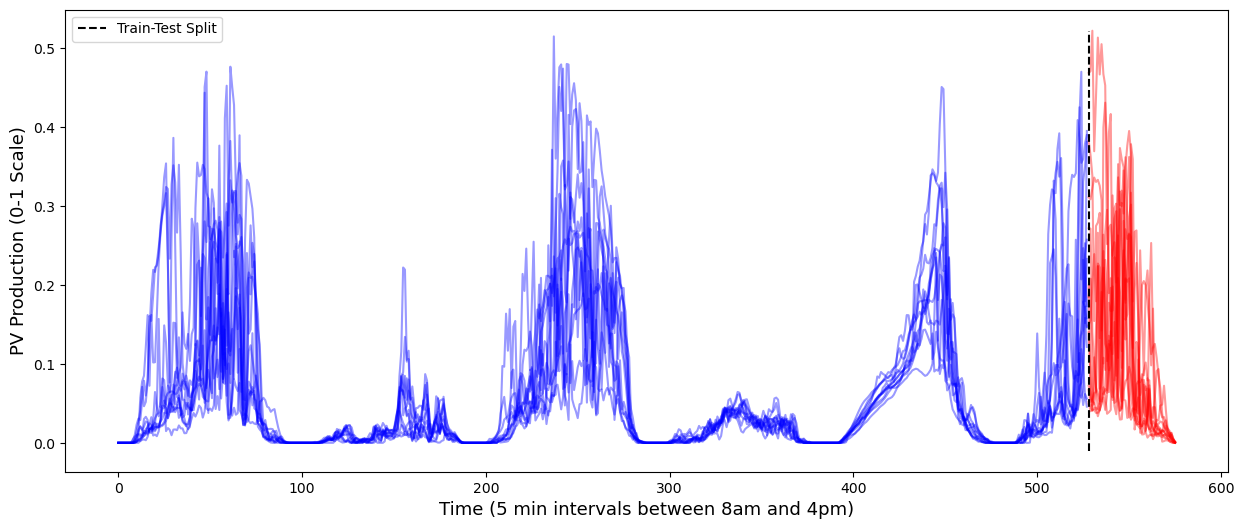

In [8]:
plot_train_test_split(y_train, y_test)

In [10]:
from kernels.quasi_periodic import generate_quasi_periodic
kernel = generate_quasi_periodic()

Iter 30/300 - Loss: -3.465
Iter 60/300 - Loss: -3.637
Iter 90/300 - Loss: -3.706
Iter 120/300 - Loss: -3.746
Iter 150/300 - Loss: -3.774
Iter 180/300 - Loss: -3.796
Iter 210/300 - Loss: -3.813
Iter 240/300 - Loss: -3.827
Iter 270/300 - Loss: -3.839
Iter 300/300 - Loss: -3.849


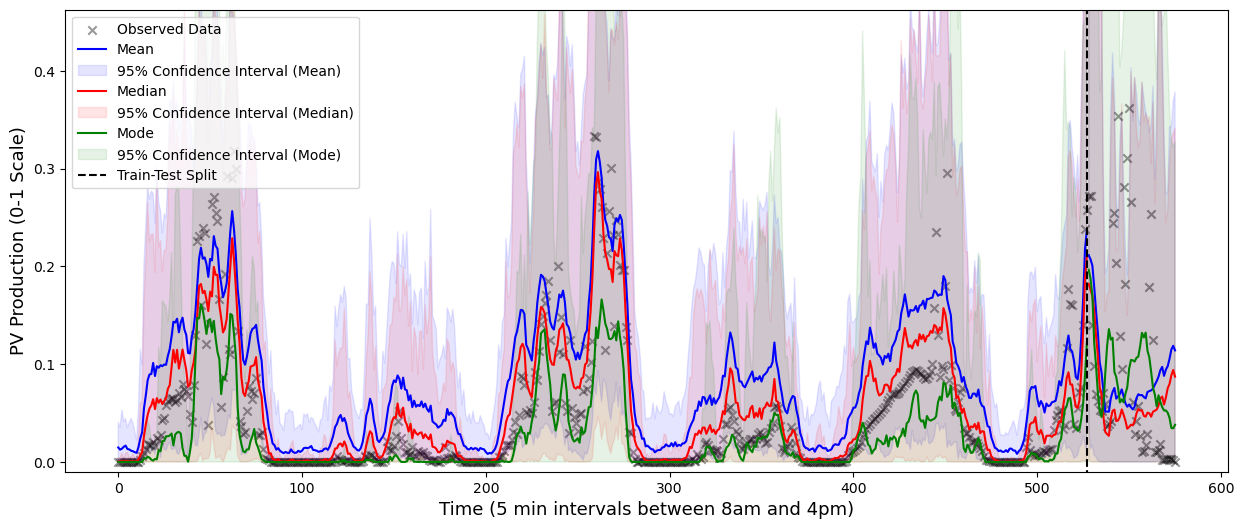

Iter 30/300 - Loss: -2.694
Iter 60/300 - Loss: -2.887
Iter 90/300 - Loss: -2.960
Iter 120/300 - Loss: -3.005
Iter 150/300 - Loss: -3.037
Iter 180/300 - Loss: -3.062
Iter 210/300 - Loss: -3.082
Iter 240/300 - Loss: -3.099
Iter 270/300 - Loss: -3.114
Iter 300/300 - Loss: -3.127


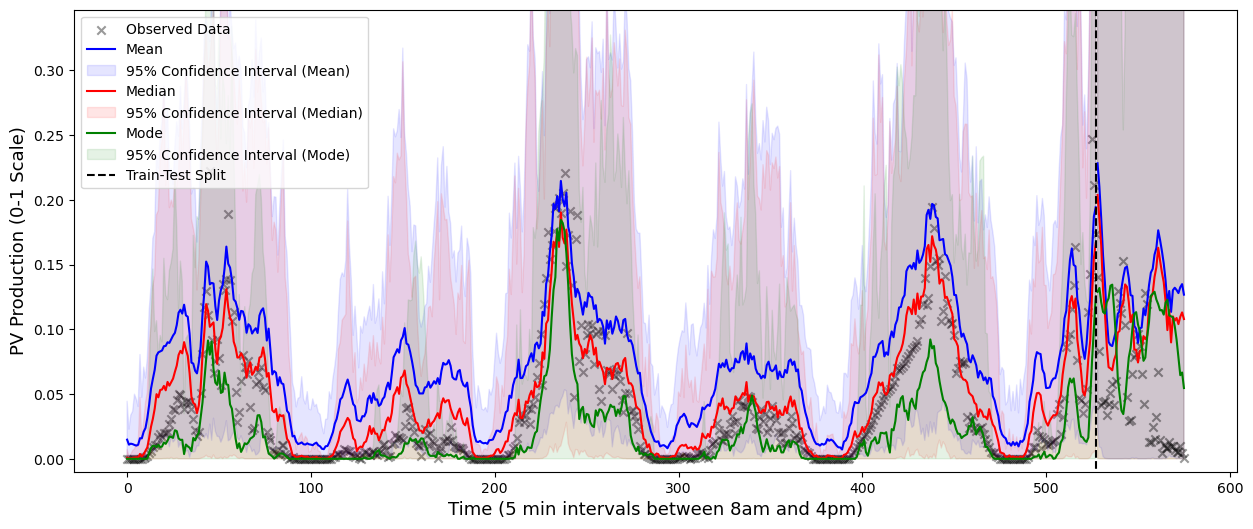

Iter 30/300 - Loss: -2.514
Iter 60/300 - Loss: -2.701
Iter 90/300 - Loss: -2.774
Iter 120/300 - Loss: -2.818
Iter 150/300 - Loss: -2.851
Iter 180/300 - Loss: -2.876
Iter 210/300 - Loss: -2.897
Iter 240/300 - Loss: -2.914


KeyboardInterrupt: 

In [15]:
jitter = 1e-2
config = {  'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': x_train.size(0),
            'mean_init_std': 1,
            }

for idx in range(y_train.size(1)):
    
  
    inputs_mean = { 'X': x_train, 
                    'y': y_train[:, idx], 
                    'mean_module': gpytorch.means.ConstantMean(),
                    'covar_module': gpytorch.kernels.RBFKernel(),#kernel,
                    'likelihood': BetaLikelihood_MeanParametrization(scale=1,
                                                                     correcting_scale=1,
                                                                     lower_bound=0.10,
                                                                     upper_bound=0.80),
                    'config': config,
                    'jitter': jitter
                }

    model_beta = ApproximateGPBaseModel(**inputs_mean)
    model_beta.fit(n_iter=300, lr=0.1,  verbose=True)    
    
    preds = model_beta.predict(X)
    plot_gp(model_beta, x_train, x_test, y_train[:,idx], y_test[:,idx], pred_type='all')